In [1]:
import control
import foton
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from timeit import default_timer as timer
import vishack
import yaml

import x1sim


dof = "SRCL"
arm = x1sim.x1sim()


def load_yaml(mdl, f, prefix=''):
    cfg = yaml.safe_load(f)

    for var, val in cfg['vars'].items():
        mdl.write(prefix + var, val)

    for fm_name in cfg['filters']:
        mdl.fm_set_switches(prefix + fm_name, **cfg['filters'][fm_name]['switches'])
        for section_name in [f'FM{n+1}' for n in range(10)]:
            sos = cfg['filters'][fm_name][section_name]['coef']
            mdl.fm_set_sos(prefix + fm_name, section_name, sos, format='o')
            settings = cfg['filters'][fm_name][section_name]['settings']
            mdl.fm_set_filter_settings(prefix + fm_name, section_name, **settings)

            
with open(f'x1sim_{dof}.yaml') as f:
    load_yaml(arm, f)

In [2]:
# fetch data.
arm.sleep(0)  # settle time
dur = 1200
t0 = timer()
chan_names = ["CTRL_IN1", "CTRL_OUT"]
bufs = arm.fetch(0, dur, chan_names)
print("Took {:0.1f} s to get ".format(timer()-t0) + str(dur) + " s of sim data.")

Took 1.4 s to get 1200 s of sim data.


In [3]:
ctrl_in = bufs[0].data
ctrl_out = bufs[1].data

In [4]:
fs = arm.sample_rate

# Takes 5 averages
f, ctrl_out_psd = scipy.signal.welch(ctrl_out, fs=fs, nperseg=(len(ctrl_in)/5))
f, ctrl_in_psd = scipy.signal.welch(ctrl_in, fs=fs, nperseg=(len(ctrl_out)/5))

ctrl_out_asd = ctrl_out_psd**.5  # To ASD
ctrl_in_asd = ctrl_in_psd**.5

In [5]:
data = vishack.data.diaggui.Diaggui("data/241113-SRCL_IN_OUT.xml")

f_, srcl_in = data.psd("L1:LSC-SRCL_IN1_DQ")
f_, srcl_out = data.psd("L1:LSC-SRCL_OUT_DQ")

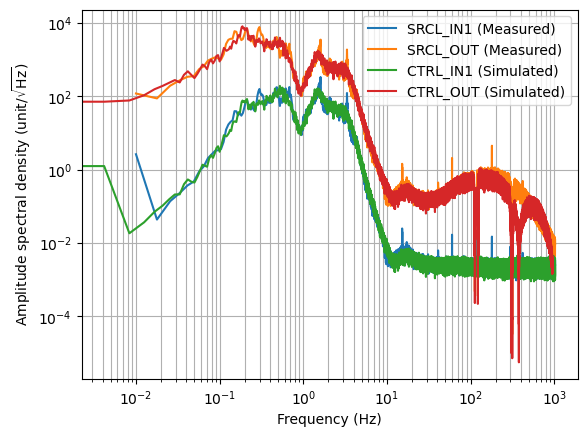

In [9]:
plt.loglog(f_, srcl_in, label="SRCL_IN1 (Measured)")
plt.loglog(f_, srcl_out, label="SRCL_OUT (Measured)")
plt.loglog(f, ctrl_in_asd, label="CTRL_IN1 (Simulated)", visible=True)
plt.loglog(f[f<950], ctrl_out_asd[f<950], label="CTRL_OUT (Simulated)", visible=True)

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude spectral density (unit/$\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
plt.savefig("srcl_sim_in_out.png", bbox_inches="tight")